In [40]:
#Import all libraries needed
import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             roc_auc_score, roc_curve, auc)

# Display our plots directly inside the outputs in our Jupyter notebook
get_ipython().run_line_magic('matplotlib', 'inline')

In [52]:
#Load our data set into the notebook 
df = pd.read_csv('imdb_movies_dataset.csv')

#CLEANING DATA

#First, we will convert the runtime column to numeric integer values only, instead of strings 
#set up function to convert our runtime to total minutes
def convert_runtime_to_minutes(run_time_str):
    #if the entry contains a string value (such as h or m)
    if isinstance(run_time_str, str):
        #define our variables hours and minutes 
        hours = re.search(r'(\d+)h', run_time_str)
        minutes = re.search(r'(\d+)m', run_time_str)
        #set the total minutes variable equal to zero
        total = 0
        #convert the value of houts to minutes by multiplying by 60
        if hours:
            total += int(hours.group(1)) * 60
        #add the minutes value to the total runtime value 
        if minutes:
            total += int(minutes.group(1))
        return total
    return None
#change our run_time column to the new runtime_minutes column for easier calculations
df['runtime_minutes'] = df['run_time'].apply(convert_runtime_to_minutes)

#Drop any missing values in the new df containing the new runtime_minutes column
df = df.dropna(subset=['rating', 'runtime_minutes', 'genre']).copy()

#Clean the genre column, we will split the entry if there is a comma, listing a second genre, and then remove the second genre so that 
#our genres are more simple and only include the first genre listed for each entry
df['genre'] = df['genre'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

#Encode the genre column
encoder = LabelEncoder()
df['genre_encoded'] = encoder.fit_transform(df['genre'])

#Clean the budget column
#drop any missing values from the budget column
df = df.dropna(subset=['budget']).copy()
#remove any non number values or anything that is not a decimal
df['budget'] = df['budget'].astype(str).str.replace('[^0-9.]', '', regex=True)
#Remove any entries with empty strings 
df = df[df['budget'] != '']
#convert number stings into numerical float values 
df['budget'] = df['budget'].astype(float)

#Create our binary classification label, in our case, we will label movies with rankings above or equal to 8.5 as having a high rating 
df['high_rating'] = (df['rating'] >= 8.5).astype(int)


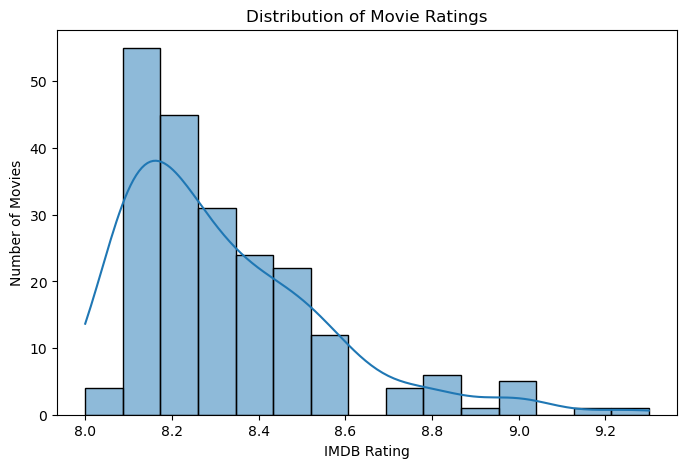

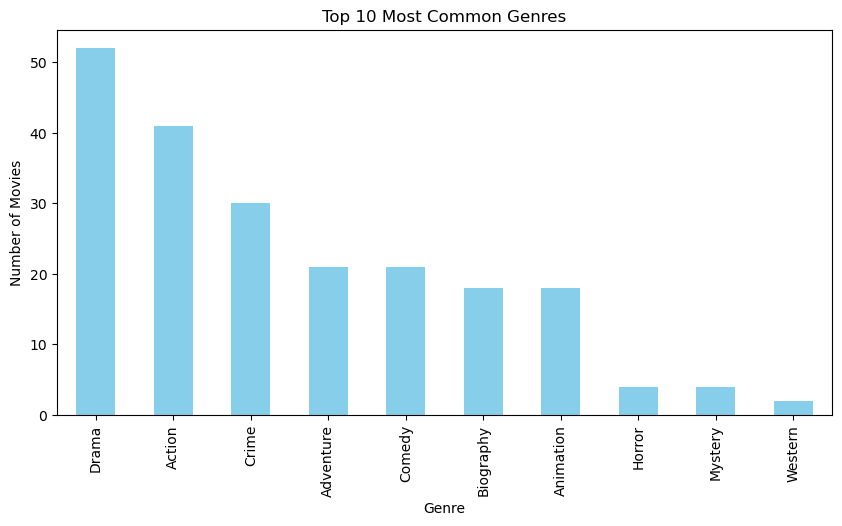

In [53]:
#Make some introductory visualizations so we can identify overall patterns and trends in our data before diving deeper into machine learning algorithms 
#First, we will create a histogram to show the distribution of movie ratings. We will show how many movies received each rating 
#Establish figure size 
plt.figure(figsize=(8,5))
#create histogram based on rating column, establish number of bins in histogram
sns.histplot(df['rating'], bins=15, kde=True)
#Histogram title 
plt.title('Distribution of Movie Ratings')
#Histogram x label
plt.xlabel('IMDB Rating')
#Histogram y label
plt.ylabel('Number of Movies')
#Display histogram 
plt.show()

#Next, we will create a bar chart to show how many movies we have in each genre, and we will display the top 10 most common genres 
#Establish figure size 
plt.figure(figsize=(10,5))
#create a bar chart for genre based on how many movies are in each genre 
df['genre'].value_counts().head(10).plot(kind='bar', color='skyblue')
#bar chart title 
plt.title('Top 10 Most Common Genres')
#bar chart x and y labels 
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
#display our bar chart 
plt.show()


Random Forest Accuracy: 0.812
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        52
           1       0.50      0.08      0.14        12

    accuracy                           0.81        64
   macro avg       0.66      0.53      0.52        64
weighted avg       0.76      0.81      0.75        64



C:\Users\Emma Brookins\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost Accuracy: 0.734
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        52
           1       0.27      0.25      0.26        12

    accuracy                           0.73        64
   macro avg       0.55      0.55      0.55        64
weighted avg       0.73      0.73      0.73        64



C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\3434015946.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


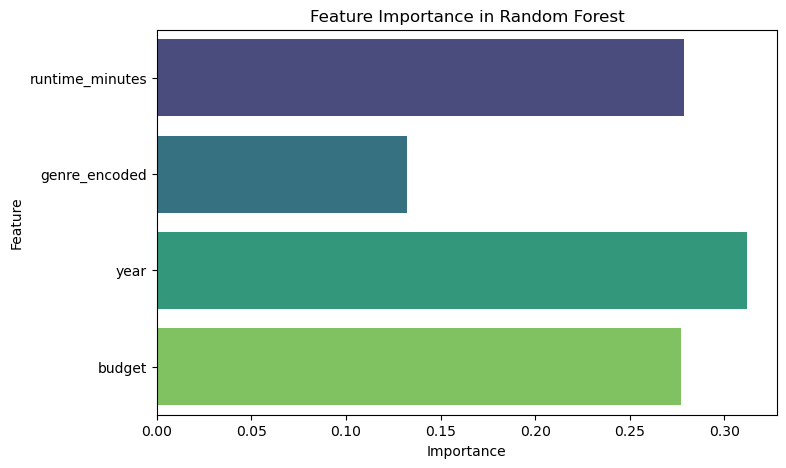

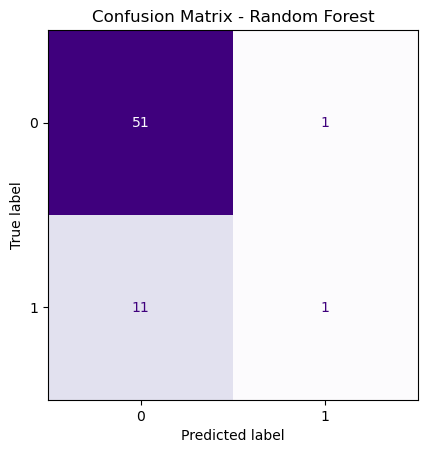

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\3434015946.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


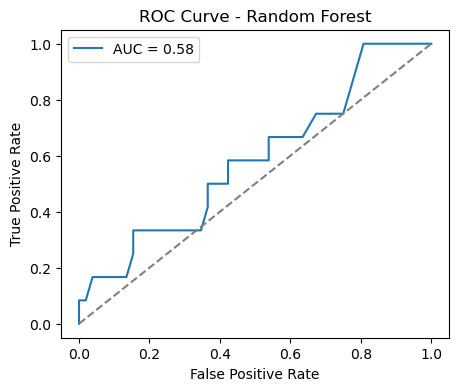

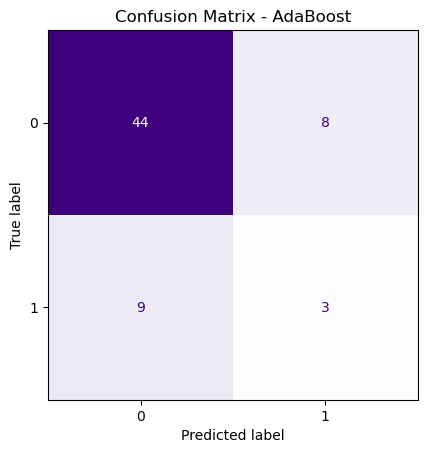

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\3434015946.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


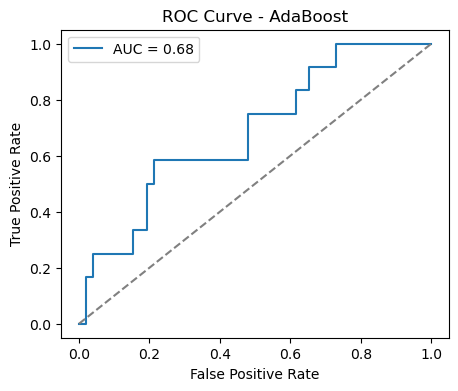

In [43]:
#drop all missing values from the columns we want to use in our model
df_model = df[['runtime_minutes', 'genre_encoded', 'year', 'budget', 'high_rating']].dropna()
#Etsablish Input columns  
X = df_model[['runtime_minutes', 'genre_encoded', 'year', 'budget']]
#output feature 
y = df_model['high_rating']
#z score normalization so all features are on same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Estalish training and testing splits 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

#Train our models for random forest and adaboost classification, pass number of estimators, random state, 
#learning rate for adaboost, and balance classes for random forest 
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=42)

#Create a list of models for the models we just created for classification 
models = {
    "Random Forest": rf_model,
    "AdaBoost": ada_model
}
#loop over the models in our list 
for name, model in models.items():
    #fit the model to the training data 
    model.fit(X_train, y_train)
    #make predictions for the testing data 
    preds = model.predict(X_test)
    #display accuracy
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.3f}")
    #display classification metrics
    print(classification_report(y_test, preds))

#Create bar plot for feature importances in random forest 
#create variable to store importances for each feature 
importances = rf_model.feature_importances_
#establish what features we want to use 
features = ['runtime_minutes', 'genre_encoded', 'year', 'budget']
#Establish figure size 
plt.figure(figsize=(8,5))
#create bar plot using our features and their importances 
sns.barplot(x=importances, y=features, palette='viridis')
#bar plot titles 
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
#bar plot x and y labels 
plt.ylabel('Feature')
#display bar plot 
plt.show()

#for each model in our list 
for name, model in models.items():
    #make predictions on testing data 
    preds = model.predict(X_test)
    #calculate the probability of each movie being highly ranked (class=1)
    probs = model.predict_proba(X_test)[:, 1]
    #create confusion matrix
    cm = confusion_matrix(y_test, preds)
    #display confusion matrix 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Purples', colorbar=False)
    #confusion matrix title for each model 
    plt.title(f'Confusion Matrix - {name}')
    #show confusion matrix 
    plt.show()
    #create roc curves for each model 
    fpr_curve, tpr_curve, _ = roc_curve(y_test, probs)
    #store AUC values 
    roc_auc = auc(fpr_curve, tpr_curve)
    #Establish figure size 
    plt.figure(figsize=(5,4))
    #plot ROC curves, add label to display AUC
    plt.plot(fpr_curve, tpr_curve, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'k--', color='gray')
    #Titles for ROC curve for each model 
    plt.title(f'ROC Curve - {name}')
    #ROC curves x and y labels 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #add legend 
    plt.legend()
    #display plots 
    plt.show()

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

#we will create a new function to run on each of our models to create confusion matrices and ROC curves for each. 
#we need to pass the function the name, model, our testing data, and our ptedictions 
def evaluate_model(name, model, X_test, y_test, y_pred):
    #Create a confusion matrix for each model 
    cm = confusion_matrix(y_test, y_pred)
    #Display layout features 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Purples', colorbar=False)
    #Confusion matrix titles based on model in use 
    plt.title(f'Confusion Matrix - {name}')
    #Display confusion matrix 
    plt.show()

    #for each model, calculate probability that each movie will be in class 1 (highly ranked)
    probs = model.predict_proba(X_test)[:, 1]
    #compute and store true positive rates and false positive rates 
    fpr_curve, tpr_curve, _ = roc_curve(y_test, probs)
    #compute auc for our roc curves using false and true positive rates 
    roc_auc = auc(fpr_curve, tpr_curve)
    #Estalish figure size 
    plt.figure(figsize=(5,4))
    #plot roc curves 
    plt.plot(fpr_curve, tpr_curve, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'k--', color='gray')
    #roc curve title based on model in use 
    plt.title(f'ROC Curve - {name}')
    #roc curve x and y labels 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #create legend 
    plt.legend()
    #display ROC curve and AUC 
    plt.show()


Logistic Regression (Genre) Accuracy: 0.53125


C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\3020908058.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_success.index, y=genre_success.values, palette='viridis')


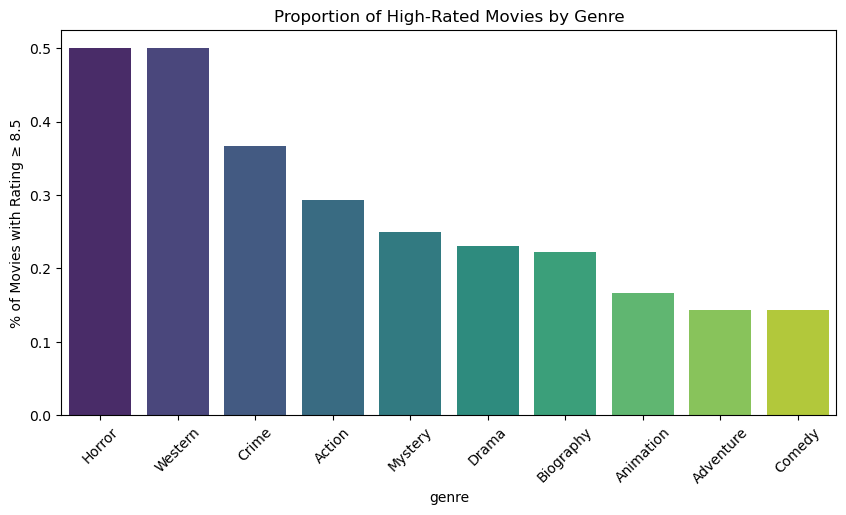

              precision    recall  f1-score   support

           0       0.79      0.58      0.67        52
           1       0.15      0.33      0.21        12

    accuracy                           0.53        64
   macro avg       0.47      0.46      0.44        64
weighted avg       0.67      0.53      0.58        64



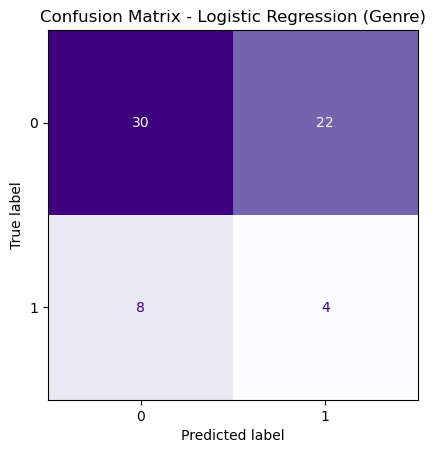

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\1872041345.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


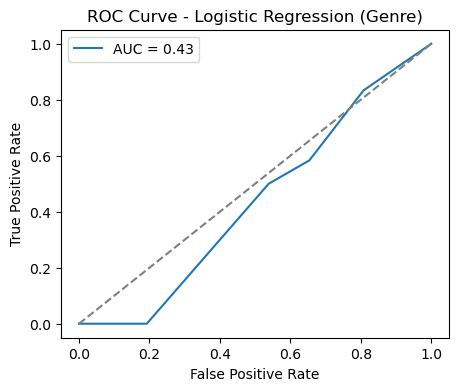

In [55]:
#Now, we will start using logistic regression on single features. We will start with genre. 

#Input=genre, output=high_rating 
Xg = df[['genre_encoded']]
yg = df['high_rating']
#Training and testing splits 
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.3, random_state=42)
#Create genre model that uses logistic regression, blance class weights 
genre_model = LogisticRegression(class_weight='balanced', max_iter=1000)
#fit the model on our training data 
genre_model.fit(Xg_train, yg_train)
#calculate predictions based on genre model 
y_pred_g = genre_model.predict(Xg_test)
#Calculate and display accuracy for genre model 
print("\nLogistic Regression (Genre) Accuracy:", accuracy_score(yg_test, y_pred_g))

#Now we will create a bar plot showing the proportion of highly rated movies per genre, using logistic regression for genre only 
#calculate proportions of highly rated movies per genre 
genre_success = df.groupby('genre')['high_rating'].mean().sort_values(ascending=False)
#Establish figure size 
plt.figure(figsize=(10,5))
#create bar plot with proportion values, separated by genre 
sns.barplot(x=genre_success.index, y=genre_success.values, palette='viridis')
#rotate x ticks so we can see longer genre names more easily 
plt.xticks(rotation=45)
#bar plot title 
plt.title('Proportion of High-Rated Movies by Genre')
#bar plot y label 
plt.ylabel('% of Movies with Rating ≥ 8.5')
#display bar plot 
plt.show()
#display classification metrics for genre model 
print(classification_report(yg_test, y_pred_g))
#run evaluate model function to get confusion matrix and ROC curve 
evaluate_model("Logistic Regression (Genre)", genre_model, Xg_test, yg_test, y_pred_g)


Logistic Regression (Runtime) Accuracy: 0.625


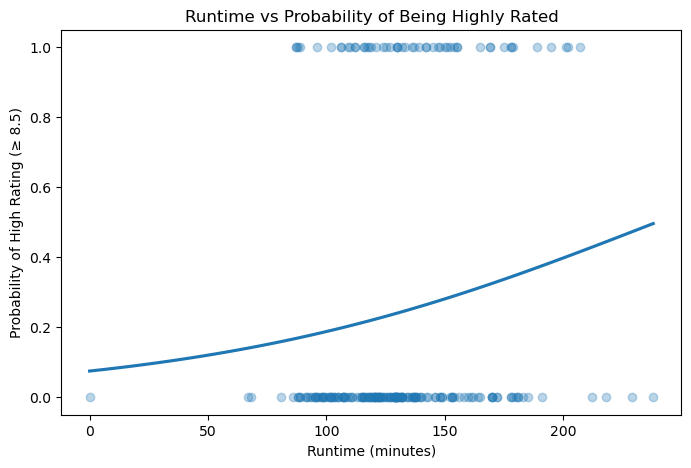

              precision    recall  f1-score   support

           0       0.87      0.63      0.73        52
           1       0.27      0.58      0.37        12

    accuracy                           0.62        64
   macro avg       0.57      0.61      0.55        64
weighted avg       0.76      0.62      0.66        64



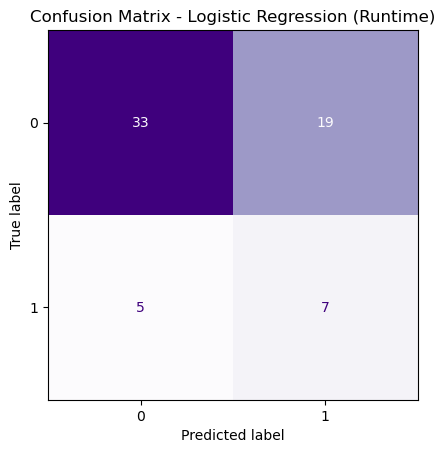

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\1872041345.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


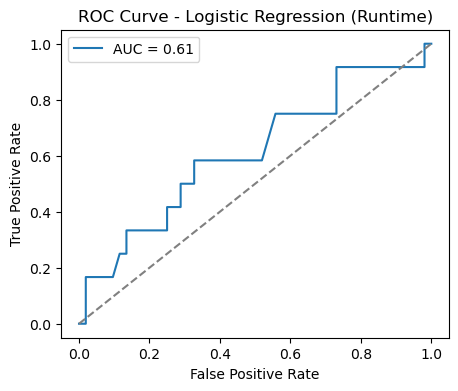

In [56]:
#Now we will do the same for runtime_minnutes 
#Input =runtime_minutes, Output = high_rating 
Xr = df[['runtime_minutes']]
yr = df['high_rating']
#scale runtime_minutes 
Xr_scaled = scaler.fit_transform(Xr)
#Training and testing splits 
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_scaled, yr, test_size=0.3, random_state=42)
#Create runtime model using logistic regression, balance class weights 
runtime_model = LogisticRegression(class_weight='balanced', max_iter=1000)
#fit model on training data 
runtime_model.fit(Xr_train, yr_train)
#calculate predictions for out runtime model on testing data 
y_pred_r = runtime_model.predict(Xr_test)
#Calculate and display accuracies 
print("\nLogistic Regression (Runtime) Accuracy:", accuracy_score(yr_test, y_pred_r))

#Now, create regression curve/plot  to visualize the relationship
#Establish figure size 
plt.figure(figsize=(8,5))
#create regression plot using runtime_minutes and high_rating 
sns.regplot(x=df['runtime_minutes'], y=df['high_rating'], logistic=True, ci=None, scatter_kws={'alpha':0.3})
#regression plot title 
plt.title('Runtime vs Probability of Being Highly Rated')
#regression plot x and y labels 
plt.xlabel('Runtime (minutes)')
plt.ylabel('Probability of High Rating (≥ 8.5)')
#display regression plot 
plt.show()
#display classification metrics for runtime model 
print(classification_report(yr_test, y_pred_r))
#run evaluate model function to get confusion matrix and ROC curve 
evaluate_model("Logistic Regression (Runtime)", runtime_model, Xr_test, yr_test, y_pred_r)


Logistic Regression (Budget) Accuracy: 0.34375


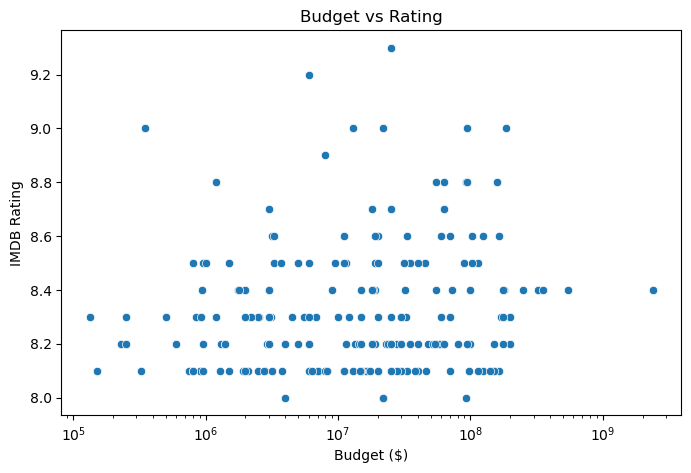

              precision    recall  f1-score   support

           0       0.78      0.27      0.40        52
           1       0.17      0.67      0.28        12

    accuracy                           0.34        64
   macro avg       0.48      0.47      0.34        64
weighted avg       0.66      0.34      0.38        64



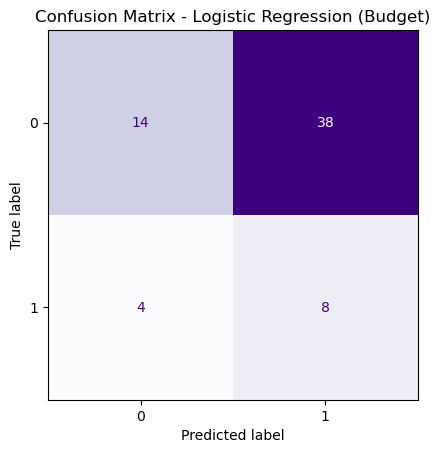

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\1872041345.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


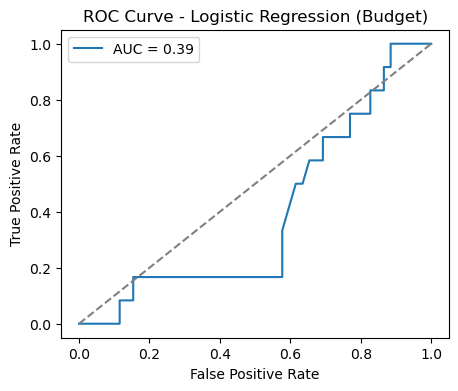

In [57]:
#Now we will do the same for budget 
#input=budget, output=high_rating 
Xb = df[['budget']]
yb = df['high_rating']
#scale/normalize budget data 
Xb_scaled = scaler.fit_transform(Xb)
#training and testing splits 
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb_scaled, yb, test_size=0.3, random_state=42)
#create budget model using logistic regression, balance classes 
budget_model = LogisticRegression(class_weight='balanced', max_iter=1000)
#fit budget model on training data 
budget_model.fit(Xb_train, yb_train)
#calculate predictions for budget model on testing data  
y_pred_b = budget_model.predict(Xb_test)
#calculate and display accuracy for budget model 
print("\nLogistic Regression (Budget) Accuracy:", accuracy_score(yb_test, y_pred_b))

#Now we will create a scatter plot for budget vs rating to help visualize results 
#Establish figure size 
plt.figure(figsize=(8,5))
#create scatterplot with budget on x axis and rating on y axis 
sns.scatterplot(x=df['budget'], y=df['rating'])
#scatterplot title 
plt.title('Budget vs Rating')
#scatterplot x and y labels 
plt.xlabel('Budget ($)')
plt.ylabel('IMDB Rating')
#display budget in log format to make easier to read 
plt.xscale('log')
#display scatter plot 
plt.show()
#display classification metrics for budget model 
print(classification_report(yb_test, y_pred_b))
#run evaluate model function to get confusion matrix and ROC curve 
evaluate_model("Logistic Regression (Budget)", budget_model, Xb_test, yb_test, y_pred_b)


Logistic Regression (Year) Accuracy: 0.453125


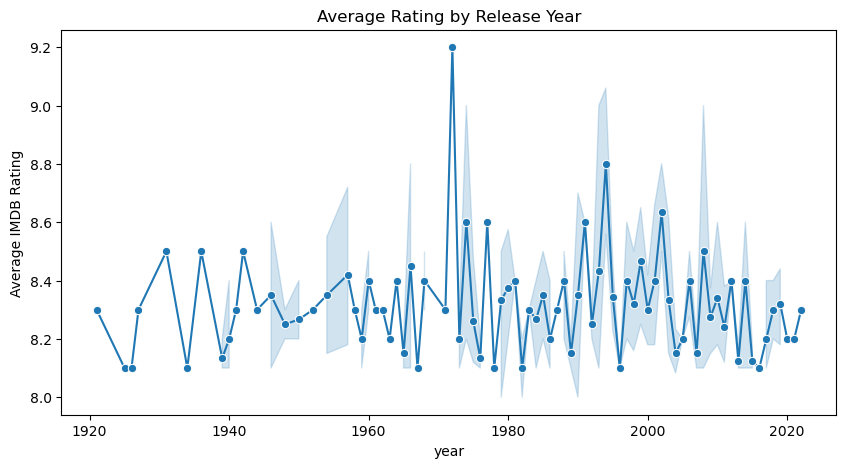

              precision    recall  f1-score   support

           0       0.76      0.48      0.59        52
           1       0.13      0.33      0.19        12

    accuracy                           0.45        64
   macro avg       0.44      0.41      0.39        64
weighted avg       0.64      0.45      0.51        64



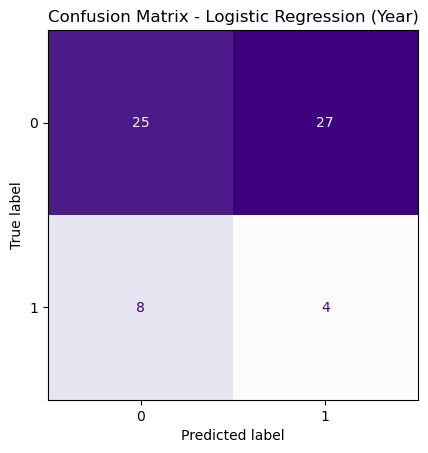

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\1872041345.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


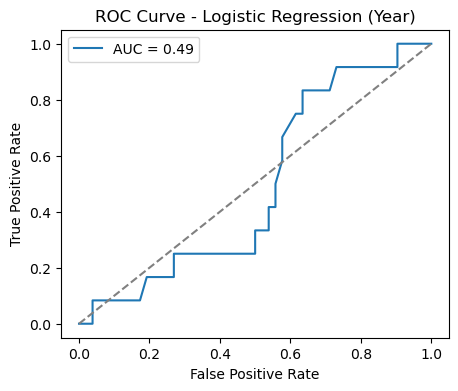

In [58]:
#Now we will do the same for year, using the same steps 
Xy = df[['year']]
yy = df['high_rating']
Xy_scaled = scaler.fit_transform(Xy)
Xy_train, Xy_test, yy_train, yy_test = train_test_split(Xy_scaled, yy, test_size=0.3, random_state=42)

year_model = LogisticRegression(class_weight='balanced', max_iter=1000)
year_model.fit(Xy_train, yy_train)
y_pred_y = year_model.predict(Xy_test)

print("\nLogistic Regression (Year) Accuracy:", accuracy_score(yy_test, y_pred_y))

#Create lineplot for average rating by movie release year 
plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='rating', data=df, marker='o')
plt.title('Average Rating by Release Year')
plt.ylabel('Average IMDB Rating')
plt.show()
#display classification metrics for year model 
print(classification_report(yy_test, y_pred_y))
#run evaluate model function to get confusion matrix and ROC curve 
evaluate_model("Logistic Regression (Year)", year_model, Xy_test, yy_test, y_pred_y)

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\3795632532.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=accuracies, palette='viridis')


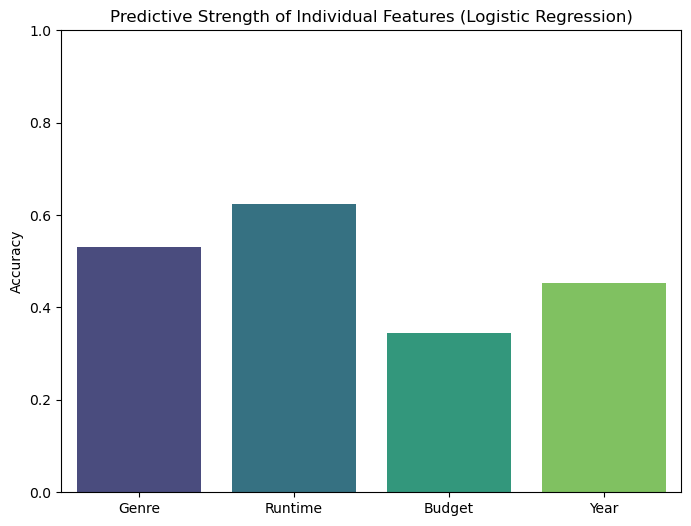

In [48]:
#Use feature previously used for logistic regression 
#store feature names in a new list 
feature_names = ['Genre', 'Runtime', 'Budget', 'Year']
#compute accuracies of the predictions for each of our models previously created, store in new list
accuracies = [
    accuracy_score(yg_test, y_pred_g),   # Genre
    accuracy_score(yr_test, y_pred_r),   # Runtime
    accuracy_score(yb_test, y_pred_b),   # Budget
    accuracy_score(yy_test, y_pred_y)    # Year
]
#Create a bar plot to show the accuracies of each model  
#Establish figure size 
plt.figure(figsize=(8,6))
#create bar plot with features on the x axis and accuracies on y axis 
sns.barplot(x=feature_names, y=accuracies, palette='viridis')
#bar plot title 
plt.title('Predictive Strength of Individual Features (Logistic Regression)')
#bar plot y label 
plt.ylabel('Accuracy')
#make sure all accuracies shown are between 0 and 1 
plt.ylim(0,1)
#display bar plot 
plt.show()



Logistic Regression (All Features) Accuracy: 0.578125
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        52
           1       0.24      0.58      0.34        12

    accuracy                           0.58        64
   macro avg       0.55      0.58      0.52        64
weighted avg       0.74      0.58      0.62        64



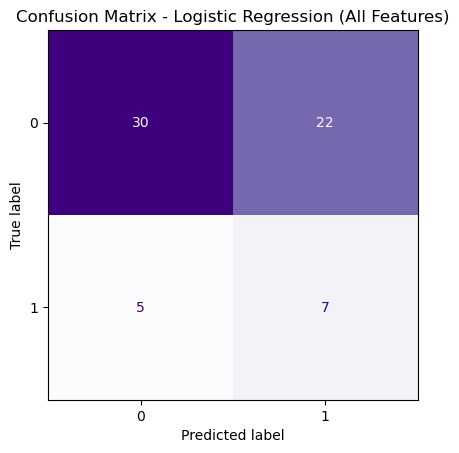

C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\1135559152.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


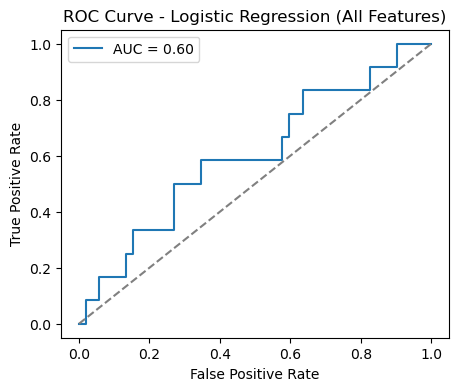

In [11]:
#Now we want to look at logistic regression for all of the features combined 
#input=all features combined, output=high_rating 
X_all = df[['genre_encoded', 'runtime_minutes', 'budget', 'year']]
y_all = df['high_rating']

#Scale/normalize input data 
X_all_scaled = scaler.fit_transform(X_all)

#Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_all, test_size=0.3, random_state=42
)

#Use logistic regression and save to new model for all features
full_model = LogisticRegression(class_weight='balanced', max_iter=1000)
#fit new model on training data 
full_model.fit(X_train, y_train)

#Calculate predictions of ratings for our new model using all features 
y_pred_full = full_model.predict(X_test)

#Calculate and display accuracy
print("\nLogistic Regression (All Features) Accuracy:", accuracy_score(y_test, y_pred_full))
#display classification metrics for full model 
print(classification_report(y_test, y_pred_full))
#run evaluate model function to get confusion matrix and ROC curve 
evaluate_model("Logistic Regression (All Features)", full_model, X_test, y_test, y_pred_full)

<Figure size 1000x600 with 0 Axes>

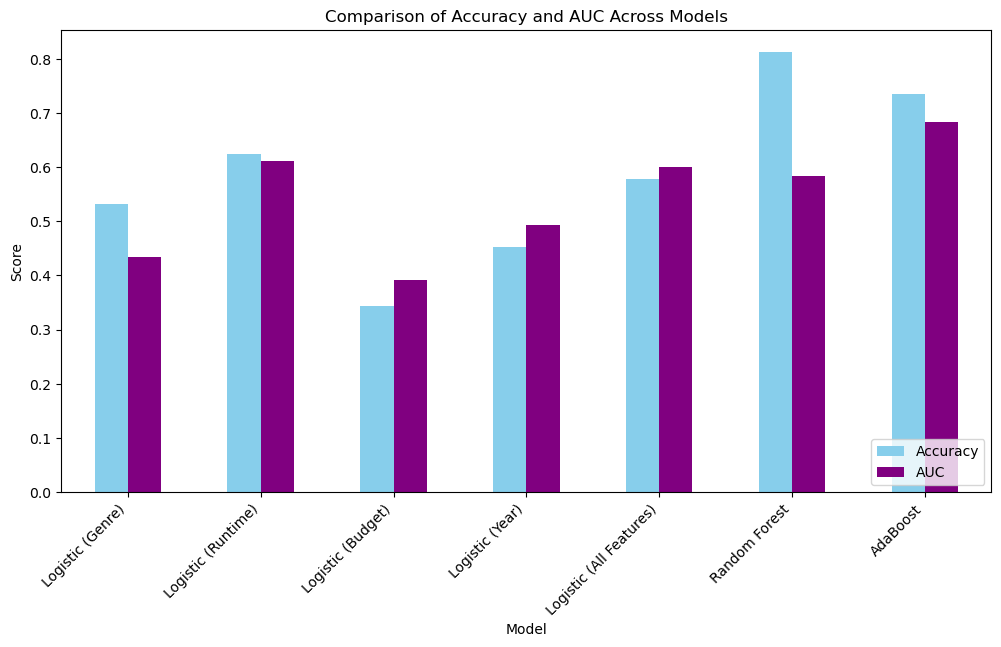

                     Model  Accuracy       AUC
0         Logistic (Genre)  0.531250  0.434295
1       Logistic (Runtime)  0.625000  0.611378
2        Logistic (Budget)  0.343750  0.391827
3          Logistic (Year)  0.453125  0.492788
4  Logistic (All Features)  0.578125  0.600962
5            Random Forest  0.812500  0.583333
6                 AdaBoost  0.734375  0.684295


In [49]:
#Now we will create a bar chart to show the accuracies and AUCs for each method we used for binary classification 
#create a new empty list that will store all of our results 
summary_results = []
#store all of our models for the single feature predictions in a new list 
single_models = {
    "Logistic (Genre)": (genre_model, Xg_test, yg_test, y_pred_g),
    "Logistic (Runtime)": (runtime_model, Xr_test, yr_test, y_pred_r),
    "Logistic (Budget)": (budget_model, Xb_test, yb_test, y_pred_b),
    "Logistic (Year)": (year_model, Xy_test, yy_test, y_pred_y)
}
#for each model in our single models list 
for name, (model, Xtest, ytest, preds) in single_models.items():
    #compute accuracy of predictions 
    acc = accuracy_score(ytest, preds)
    #compute probability that each movie will be classified as highly ranked 
    probs = model.predict_proba(Xtest)[:, 1]
    #compute false positive rates and true positive rates for roc curves 
    fpr, tpr, _ = roc_curve(ytest, probs)
    #compute auc value for each ROC curve 
    auc_val = auc(fpr, tpr)
    #add the results to our list storing all of our results 
    summary_results.append({"Model": name, "Accuracy": acc, "AUC": auc_val})

#Repeat all of the same steps, but for the models that use a combination of the features 
combined_models = {
    "Logistic (All Features)": log_model,
    "Random Forest": rf_model,
    "AdaBoost": ada_model
}

for name, model in combined_models.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_val = auc(fpr, tpr)
    summary_results.append({"Model": name, "Accuracy": acc, "AUC": auc_val})

#Create a new data frame for our bar chart that includes all of the values from our summary of results list 
summary_df = pd.DataFrame(summary_results)

#Now we will plot the bar chart so we can compare values 
#establish figure size 
plt.figure(figsize=(10,6))
#plot bar chart for the values in our new data frame , plot accuracy and AUC for each model 
summary_df.set_index("Model")[["Accuracy","AUC"]].plot(kind="bar", figsize=(12,6), color=["skyblue","purple"])
#bar chart title 
plt.title("Comparison of Accuracy and AUC Across Models")
#Bar chart y label 
plt.ylabel("Score")
#rotate x labels for easier reading 
plt.xticks(rotation=45, ha="right")
#insert legend 
plt.legend(loc="lower right")
#display bar chart 
plt.show()

#Display our new data frame so we can check that all values are correct 
print(summary_df)


In [ ]:
##RANDOM FOREST REGRESSION 

Random Forest Regression Metrics:
MAE: 1.04 million
RMSE: 1.44 million
R²: 0.649


C:\Users\Emma Brookins\AppData\Local\Temp\ipykernel_20756\2771015667.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


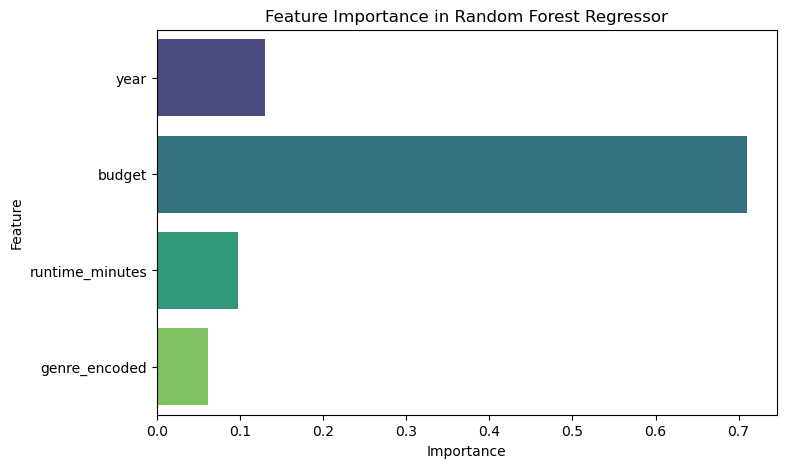

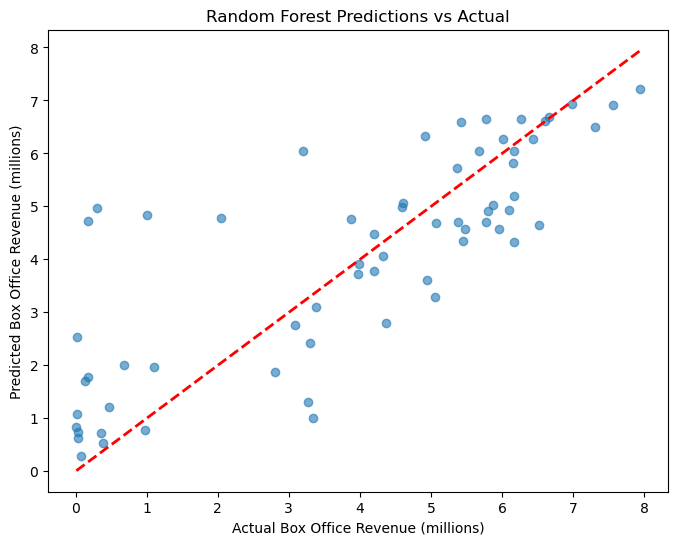

In [59]:
#Import new libraries for regression models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Clean box office column 
#Convert entries to string values and remove anything that is not a number or decimal point 
df['box_office'] = df['box_office'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
#remove any entries with missing values 
df = df[df['box_office'] != '']
#convert all strings to floats for numerical calculations 
df['box_office'] = df['box_office'].astype(float)
#Convert values to millions of dollars for easier intepretation of calculations 
df['box_office'] = df['box_office'] / 1e6
#take the log of all of the values in millions 
df['box_office'] = np.log1p(df['box_office'])

#create new list of features that we will be using for our regression models 
features = ['year', 'budget', 'runtime_minutes', 'genre_encoded']
#establish our target feature, box_office 
target = 'box_office'
#input = features in features list, output=target variable (box_office)
X = df[features]
y = df[target]

#Training and testing splits 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#Fit the training data on the random forest regressor 
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=None)
rf_reg.fit(X_train, y_train)

#Use the random forest regressor to make predictions for testing data 
y_pred = rf_reg.predict(X_test)

#Calculate regression metrics for random forest (MAE,RSME,R^2)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#Display regression metrics for random forest 
print("Random Forest Regression Metrics:")
print(f"MAE: {mae:,.2f} million")
print(f"RMSE: {rmse:,.2f} million")
print(f"R²: {r2:.3f}")

#calculate feature importances for the features in the features list of the random forest regressor 
importances = rf_reg.feature_importances_
#Establish figure size 
plt.figure(figsize=(8,5))
#create bar plot to show features on the y axis and importances on the x axis
sns.barplot(x=importances, y=features, palette='viridis')
#Bar plot title 
plt.title('Feature Importance in Random Forest Regressor')
#Bar plot x and y labels 
plt.xlabel('Importance')
plt.ylabel('Feature')
#display bar plot 
plt.show()

#Create a scatter plot to show the predicted vs actual box office revenue in millions of dollars 
#Establish figure size 
plt.figure(figsize=(8,6))
#create scatter plot with testing and predictions 
plt.scatter(y_test, y_pred, alpha=0.6)
#insert diagonal line to show a perfict fit line that we can compare our points to 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#scatter plot x and y labels 
plt.xlabel('Actual Box Office Revenue (millions)')
plt.ylabel('Predicted Box Office Revenue (millions)')
#scatter plot title 
plt.title('Random Forest Predictions vs Actual')
#show our scatter plot 
plt.show()